## Library

In [1]:
!pip install -U \
  transformers==4.41.2 \
  datasets==2.19.0 \
  accelerate==1.7.0

!pip install --upgrade datasets
!pip install --upgrade huggingface_hub

  Using cached datasets-2.19.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-2.19.0-py3-none-any.whl (542 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 2.19.0
    Uninstalling datasets-2.19.0:
      Successfully uninstalled datasets-2.19.0


In [2]:
import os
# os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
from transformers import pipeline
from transformers import (
    SegformerImageProcessor,
    SegformerForSemanticSegmentation,
    Trainer,
    TrainingArguments,
    default_data_collator,
)
import transformers, accelerate, datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from datasets import load_dataset, DatasetDict
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, resize, to_tensor
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

2025-07-08 14:14:06.079192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751955246.106020   11922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751955246.112071   11922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-08 14:14:06.133232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model from checkpoint

In [4]:
import torch.nn.functional as F

def forward_custom(self, pixel_values):
    backbone_output = self.segformer(pixel_values)
    encoder_hidden_states = backbone_output.hidden_states[-4:]  # Use last 4 scales

    # Optional debug
    assert isinstance(encoder_hidden_states, (list, tuple))
    assert all(isinstance(t, torch.Tensor) for t in encoder_hidden_states)

    logits = self.decode_head(encoder_hidden_states)
    logits = F.interpolate(logits, size=(384, 512), mode='bilinear', align_corners=False)

    return {"logits": logits}

image_processor = SegformerImageProcessor.from_pretrained("/workspace/segformer-maritime-v2/checkpoint-2980")
model = SegformerForSemanticSegmentation.from_pretrained(
    "/workspace/segformer-maritime-v2/checkpoint-2980",
    num_labels=3,
    ignore_mismatched_sizes=True,
)
model.forward = forward_custom.__get__(model, model.__class__)
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [6]:
from torchvision.transforms import Resize, InterpolationMode
resizer = Resize((384, 512), interpolation=InterpolationMode.NEAREST)

def preprocess(example):
    processed = image_processor(example["image"], return_tensors="pt")
    label_tensor = torch.tensor(example["label"], dtype=torch.long)
    label_tensor = resizer(label_tensor.unsqueeze(0)).squeeze(0)

    label_tensor = torch.where(
        (label_tensor >= 0) & (label_tensor <= 2),
        label_tensor,
        torch.tensor(255)
    )
    return {
        "pixel_values": processed["pixel_values"].squeeze(0),
        "labels": label_tensor
    }

## Inferencing function

In [7]:
def predict_single_sample(model, pixel_values):
    model.eval()
    with torch.no_grad():
        if isinstance(pixel_values, list):
            pixel_values = torch.tensor(pixel_values)
        elif isinstance(pixel_values, np.ndarray):
            pixel_values = torch.from_numpy(pixel_values)
        
        if pixel_values.ndim == 3:
            pixel_values = pixel_values.unsqueeze(0)  # Add batch dim

        pixel_values = pixel_values.to(dtype=torch.float32, device=model.device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
    
    return preds[0].cpu().numpy()

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise TypeError(f"Unsupported type: {type(x)}")

Saved prediction mask to predicted_masks/label_20241101_path1_1_996.npy


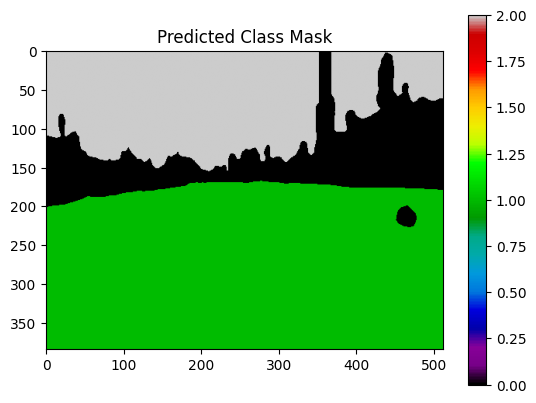

In [9]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# === Setup ===
image_path = "/workspace/label_20241101_path1_1_996.png"       # ⬅️ your specific input image
output_mask_path = "predicted_masks/label_20241101_path1_1_996.npy"  # where to save

# Load image
image = Image.open(image_path).convert("RGB")

# Preprocess
inputs = image_processor(images=image, return_tensors="pt").to(model.device)  # 'processor' must match your model

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs["logits"]  # shape: [1, num_classes, H, W]
    pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()  # shape: [H, W]

# Save prediction
os.makedirs(os.path.dirname(output_mask_path), exist_ok=True)
np.save(output_mask_path, pred_mask)
print(f"Saved prediction mask to {output_mask_path}")

# Optional debug display
plt.imshow(pred_mask, cmap="nipy_spectral")
plt.title("Predicted Class Mask")
plt.colorbar()
plt.show()

## Colorized mask

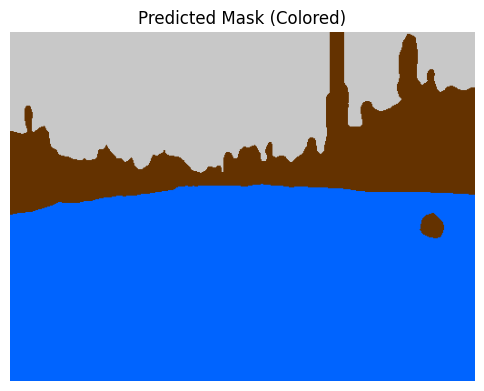

In [10]:
color_map = [
    (100,  50,   0),  # class 0 = “ship hull”
    (  0, 100, 255),  # class 1 = “water”
    (200, 200, 200),  # class 2 = “sky”
    (0, 0, 0)       # background
]

def colorize_mask(mask, color_map):
    """
    Converts a 2D class index mask to an RGB image using the given color_map.
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        color_mask[mask == class_idx] = color
    return color_mask

# === Load predicted mask ===
pred_mask = np.load("predicted_masks/label_20241101_path1_1_996.npy")  # path to your .npy mask

# === Convert to RGB and show ===
color_mask = colorize_mask(pred_mask, color_map)

plt.figure(figsize=(6, 6))
plt.imshow(color_mask)
plt.title("Predicted Mask (Colored)")
plt.axis("off")
plt.show()